In [35]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 1
input_size = 41
hidden_size = 128
num_layers = 2
num_classes = 5
batch_size = 100
num_epochs = 4
learning_rate = 0.001

# NSL-KDD datasets
df = pd.read_csv('NSL-KDD/KDDTrain+.txt', sep=',')
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'labels', 'difficulty']

# convert categorial feature into numeric
protocols = df.protocol_type.value_counts()
protocols_map = {}
for i, (prop, count) in enumerate(protocols.items()):
    protocols_map[prop] = i
df.protocol_type = df.protocol_type.map(protocols_map)

# convert categorial feature into numeric
services = df.service.value_counts()
service_map = {}
for i, (ser, count) in enumerate(services.items()):
    service_map[ser] = i
df.service = df.service.map(service_map)

# convert categorial feature into numeric
flag_map = {}
flags = df.flag.value_counts()
for i, (flag, count) in enumerate(flags.items()):
    flag_map[flag] = i
df.flag = df.flag.map(flag_map)

# Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
df['targets'] = df.labels.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1,
                                   'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1,
                                   'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,
                                   'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,
                                   'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,
                                   'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,
                                   'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,
                                   'sqlattack': 4,'xterm': 4})


In [36]:
# Datatype of target is object, change it to int 
df['targets'] = df['targets'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 44 columns):
duration                       125972 non-null int64
protocol_type                  125972 non-null int64
service                        125972 non-null int64
flag                           125972 non-null int64
src_bytes                      125972 non-null int64
dst_bytes                      125972 non-null int64
land                           125972 non-null int64
wrong_fragment                 125972 non-null int64
urgent                         125972 non-null int64
hot                            125972 non-null int64
num_failed_logins              125972 non-null int64
logged_in                      125972 non-null int64
num_compromised                125972 non-null int64
root_shell                     125972 non-null int64
su_attempted                   125972 non-null int64
num_root                       125972 non-null int64
num_file_creations             125972 non

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
# Seperate featues and target
X = df.drop(['labels', 'difficulty', 'targets'], axis=1)
y = df['targets']

In [39]:
X_train, x_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
type(X_train), type(x_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

# Constant Feature Removal

In [41]:
const_filter = VarianceThreshold(threshold=0)
const_filter.fit(X_train)

VarianceThreshold(threshold=0)

In [42]:
const_filter.get_support().sum()

39

In [43]:
constant_list = [feature for feature in const_filter.get_support()]
constant_list

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [48]:
# remaining features after removing constant feature
cols_label= X.columns[constant_list]
cols_label

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [49]:
X_train['num_outbound_cmds'].unique(), X_train['is_host_login'].unique()

(array([0]), array([0]))

In [50]:
X_train_cons_filter = const_filter.transform(X_train)
x_test_cons_filter = const_filter.transform(x_test)

In [51]:
# train and test datasets after constant feature remove
X_train_cons_filter.shape, x_test_cons_filter.shape

((100777, 39), (25195, 39))

# Quasi constant Feature Removal

In [52]:
# remove those features which are almost constant (99 percent)
quasi_constant_filter = VarianceThreshold(threshold=0.01)

In [53]:
quasi_constant_filter.fit(X_train_cons_filter)

VarianceThreshold(threshold=0.01)

In [54]:
quasi_constant_filter.get_support().sum()

31

In [56]:
X_train_quasi_constant_filter = quasi_constant_filter.transform(X_train_cons_filter)
x_test__quasi_constant_filter = quasi_constant_filter.transform(x_test_cons_filter)

In [57]:
X_train_quasi_constant_filter.shape, x_test__quasi_constant_filter.shape

((100777, 31), (25195, 31))

In [58]:
constant_list = [feature for feature in quasi_constant_filter.get_support()]
constant_list

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [59]:
# print remaining list of features
print(cols_label[constant_list]), print(len(cols_label[constant_list]))
cols_label_2 = cols_label[constant_list]

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'num_root', 'num_file_creations', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')
31


# Duplicate Feature Removal

In [60]:
X_train_T = X_train_quasi_constant_filter.T
x_test_T = x_test__quasi_constant_filter.T

In [61]:
type(X_train_T)

numpy.ndarray

In [62]:
X_train_T = pd.DataFrame(X_train_T)
x_test_T = pd.DataFrame(x_test_T)

In [63]:
X_train_T.shape, x_test_T.shape

((31, 100777), (31, 25195))

In [64]:
X_train_T.duplicated().sum()

0

In [65]:
duplicate_feaure = X_train_T.duplicated()
duplicate_feaure

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
dtype: bool

In [66]:
feature_to_keep = [not f for f in duplicate_feaure]
feature_to_keep

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [67]:
X_train_unique = X_train_T[feature_to_keep].T
x_test_unique = x_test_T[feature_to_keep].T

In [68]:
X_train_unique.shape, x_test_unique.shape

((100777, 31), (25195, 31))

In [69]:
type(X_train_unique)

pandas.core.frame.DataFrame

# Build ML model using sklearn

In [70]:
def run_randomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

In [72]:
X_train_unique.shape, x_test_unique.shape

((100777, 31), (25195, 31))

In [73]:
%%time
print('After removing constant, quasi-constant and duplicate')
run_randomForest(X_train_unique, x_test_unique, y_train, y_test)

After removing constant, quasi-constant and duplicate
Accuracy:  0.9989283588013494
CPU times: user 17.6 s, sys: 192 ms, total: 17.8 s
Wall time: 4.8 s


In [74]:
%%time
print('After removing conastant')
run_randomForest(X_train_cons_filter, x_test_cons_filter, y_train, y_test)

After removing conastant
Accuracy:  0.9990077396308792
CPU times: user 18.8 s, sys: 192 ms, total: 19 s
Wall time: 5.22 s


In [75]:
%%time
print('After removing quasi-constat')
run_randomForest(X_train_quasi_constant_filter, x_test__quasi_constant_filter, y_train, y_test)

After removing quasi-constat
Accuracy:  0.9989283588013494
CPU times: user 18.1 s, sys: 244 ms, total: 18.3 s
Wall time: 5.23 s


In [76]:
%%time
print('Without removing any features')
run_randomForest(X_train, x_test, y_train, y_test)

Without removing any features
Accuracy:  0.9989680492161143
CPU times: user 18.3 s, sys: 256 ms, total: 18.5 s
Wall time: 5.16 s


# Pearson Correlation coefficients

In [77]:
corrmat = X_train_unique.corr()

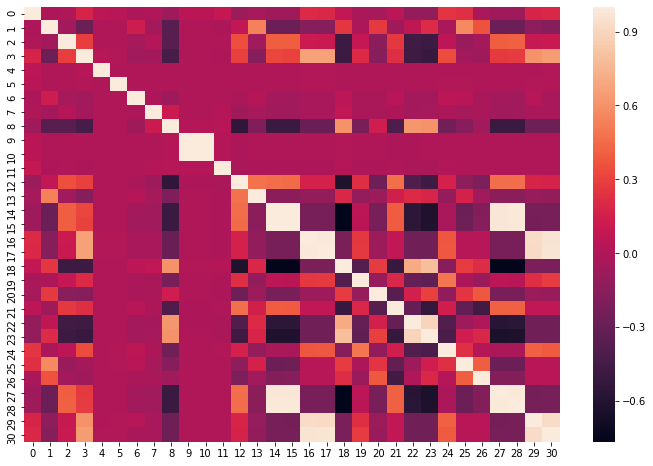

In [78]:
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

In [79]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

In [80]:
corr_features = get_correlation(X_train_unique, 0.90)
corr_features

{10, 15, 17, 27, 28, 29, 30}

In [81]:
len(corr_features)

7

In [83]:
uncorr_labesl = []
for i, col in enumerate(cols_label_2):
    if i not in corr_features:
        uncorr_labesl.append(col)
print(len(uncorr_labesl))
uncorr_labesl

24


['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'hot',
 'logged_in',
 'num_compromised',
 'num_file_creations',
 'count',
 'srv_count',
 'serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate']

In [84]:
X_train_without_corr = X_train_unique.drop(labels = corr_features, axis = 1)
X_test_without_corr = x_test_unique.drop(labels = corr_features, axis = 1)

In [85]:
X_train_without_corr.shape, X_test_without_corr.shape

((100777, 24), (25195, 24))

In [86]:
%%time 
print('After removing pearson correlation coefficient')
run_randomForest(X_train_without_corr, X_test_without_corr, y_train, y_test)

After removing pearson correlation coefficient
Accuracy:  0.9989283588013494
CPU times: user 16.5 s, sys: 248 ms, total: 16.7 s
Wall time: 4.42 s


In [352]:
# apply pearson correlation coefficient on initial datasets
print(X_train.shape)
corr_features = get_correlation(X_train, 0.90)
# corr_features
X_train_initial_corr = X_train.drop(labels = corr_features, axis = 1)
X_test_initial_corr = x_test.drop(labels = corr_features, axis = 1)
X_train_initial_corr.shape, X_test_initial_corr.shape
# print()
run_randomForest(X_train_initial_corr, X_test_initial_corr, y_train, y_test)

(100777, 41)
Accuracy:  0.9989680492161143


# pearson correlation coffecient based group

In [353]:
X_train_cons_filter = pd.DataFrame(X_train_cons_filter)
corrmat = X_train_cons_filter.corr()
corr_features = get_correlation(X_train_cons_filter, 0.90)
print(corr_features)
corrmat

{35, 36, 37, 38, 15, 23, 25}


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.000000,-0.009967,0.002528,0.176394,0.054169,0.039088,-0.001622,-0.009777,0.004586,-0.000132,...,0.050892,-0.109289,-0.115546,0.253848,0.227889,-0.026399,-0.064810,-0.063982,0.174528,0.198709
1,-0.009967,1.000000,-0.061750,-0.277219,-0.003849,-0.002367,-0.006560,0.128855,-0.003425,-0.042002,...,-0.074146,0.068764,0.209410,-0.021308,0.569278,0.364310,-0.278256,-0.277162,-0.136476,-0.166853
2,0.002528,-0.061750,1.000000,0.283294,0.004864,-0.001220,0.002541,-0.041014,0.004272,0.016806,...,0.265421,-0.464282,-0.481485,0.048423,-0.086222,-0.054611,0.404127,0.409593,0.101639,0.109540
3,0.176394,-0.277219,0.283294,1.000000,0.034534,0.011191,0.005891,-0.055612,-0.004819,-0.049942,...,0.227613,-0.472394,-0.508303,0.344514,-0.042851,-0.070647,0.273909,0.280337,0.601219,0.644820
4,0.054169,-0.003849,0.004864,0.034534,1.000000,0.000001,-0.000129,-0.000774,-0.000065,0.001265,...,-0.004400,-0.006752,-0.005766,0.000672,0.002045,-0.001513,-0.004560,-0.002192,-0.001919,0.007065
5,0.039088,-0.002367,-0.001220,0.011191,0.000001,1.000000,-0.000079,-0.000475,0.000256,-0.000396,...,0.002934,-0.004737,-0.005024,0.012385,0.013042,-0.001409,-0.003300,-0.003214,0.013181,0.012611
6,-0.001622,-0.006560,0.002541,0.005891,-0.000129,-0.000079,1.000000,-0.001316,-0.000114,-0.001398,...,-0.026695,-0.014891,0.011660,-0.004493,0.034695,0.070904,0.020422,0.013013,-0.005435,-0.005554
7,-0.009777,0.128855,-0.041014,-0.055612,-0.000774,-0.000475,-0.001316,1.000000,-0.000687,-0.008426,...,0.040414,-0.045733,-0.049032,0.056631,0.036108,-0.016115,-0.051692,-0.055601,0.028394,-0.033472
8,0.004586,-0.003425,0.004272,-0.004819,-0.000065,0.000256,-0.000114,-0.000687,1.000000,0.000484,...,-0.005726,-0.007911,-0.005887,0.005119,0.000670,0.001927,-0.004699,-0.004818,-0.002987,-0.002900
9,-0.000132,-0.042002,0.016806,-0.049942,0.001265,-0.000396,-0.001398,-0.008426,0.000484,1.000000,...,-0.011932,-0.051510,-0.035967,-0.010876,-0.034460,-0.024248,-0.058061,-0.057932,-0.029851,-0.031210


In [354]:
corr_data = corrmat.abs().stack()
corr_data

0   0     1.000000
    1     0.009967
    2     0.002528
    3     0.176394
    4     0.054169
            ...   
38  34    0.040182
    35    0.227578
    36    0.232396
    37    0.925828
    38    1.000000
Length: 1521, dtype: float64

In [355]:
corr_data = corr_data.sort_values(ascending=False)
corr_data

38  38    1.000000
18  18    1.000000
21  21    1.000000
22  22    1.000000
23  23    1.000000
            ...   
4   8     0.000065
16  5     0.000045
5   16    0.000045
4   5     0.000001
5   4     0.000001
Length: 1521, dtype: float64

In [356]:
corr_data = corr_data[corr_data>0.90]
corr_data = corr_data[corr_data<1]
corr_data

12  15    0.998950
15  12    0.998950
22  23    0.993558
23  22    0.993558
25  24    0.989219
24  25    0.989219
36  23    0.986002
23  36    0.986002
36  35    0.985073
35  36    0.985073
22  36    0.981034
36  22    0.981034
35  22    0.979045
22  35    0.979045
23  35    0.977497
35  23    0.977497
25  38    0.970648
38  25    0.970648
24  38    0.964776
38  24    0.964776
37  24    0.927218
24  37    0.927218
37  38    0.925828
38  37    0.925828
25  37    0.918888
37  25    0.918888
dtype: float64

In [357]:
corr_data = pd.DataFrame(corr_data).reset_index()
corr_data.columns = ['Feature1', 'Feature2', 'corr_value']
corr_data

,Feature1,Feature2,corr_value
0,12,15,0.998950
1,15,12,0.998950
2,22,23,0.993558
3,23,22,0.993558
4,25,24,0.989219
5,24,25,0.989219
6,36,23,0.986002
7,23,36,0.986002
8,36,35,0.985073
9,35,36,0.985073


In [358]:
grouped_feature_list = []
correlated_groups_list = []
for feature in corr_data.Feature1.unique():
    if feature not in grouped_feature_list:
        correlated_block = corr_data[corr_data.Feature1==feature]
        grouped_feature_list = grouped_feature_list + list(correlated_block.Feature2.unique())+[feature]
        correlated_groups_list.append(correlated_block)

In [359]:
len(correlated_groups_list)

3

In [360]:
correlated_groups_list

[   Feature1  Feature2  corr_value
 0        12        15     0.99895,     Feature1  Feature2  corr_value
 2         22        23    0.993558
 10        22        36    0.981034
 13        22        35    0.979045,     Feature1  Feature2  corr_value
 4         25        24    0.989219
 16        25        38    0.970648
 24        25        37    0.918888]

In [361]:
for group in correlated_groups_list:
    print(group)
    print()

   Feature1  Feature2  corr_value
0        12        15     0.99895

    Feature1  Feature2  corr_value
2         22        23    0.993558
10        22        36    0.981034
13        22        35    0.979045

    Feature1  Feature2  corr_value
4         25        24    0.989219
16        25        38    0.970648
24        25        37    0.918888



In [362]:
important_feature = []
for group in correlated_groups_list:
    features = list(group.Feature1.unique())+ list(group.Feature2.unique())
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_train_cons_filter[features], y_train)
    
    importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
    importance.columns = ['features', 'importance']
    importance.sort_values(by ='importance', ascending = False, inplace = True)
    feat = importance.iloc[0]
    important_feature.append(feat)

In [363]:
important_feature

[features      12.000000
 importance     0.678742
 Name: 0, dtype: float64, features      35.000000
 importance     0.473006
 Name: 3, dtype: float64, features      37.000000
 importance     0.408372
 Name: 3, dtype: float64]

In [364]:
important_feature = pd.DataFrame(important_feature)
important_feature.reset_index(inplace = True, drop = True)
important_feature

,features,importance
0,12.0,0.678742
1,35.0,0.473006
2,37.0,0.408372


In [365]:
features_to_consider = set(important_feature['features'])
features_to_remove = set(corr_features) -set(features_to_consider)
features_to_remove = list(features_to_remove)
features_to_remove

[36, 38, 15, 23, 25]

In [366]:
X_train_grouped_uncorr = X_train_cons_filter.drop(labels=features_to_remove, axis = 1)
X_train_grouped_uncorr.shape

(100777, 34)

In [367]:
x_test_cons_filter = pd.DataFrame(x_test_cons_filter)
X_test_grouped_uncorr = x_test_cons_filter.drop(labels=features_to_remove, axis =1)
X_test_grouped_uncorr.shape

(25195, 34)

In [368]:
%%time 
run_randomForest(X_train_grouped_uncorr, X_test_grouped_uncorr, y_train, y_test)

Accuracy:  0.9989283588013494
CPU times: user 15.8 s, sys: 288 ms, total: 16.1 s
Wall time: 4.9 s


In [374]:
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import svm

In [370]:
def run_DecisionTreeClassifier(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

In [371]:
def run_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(n_estimators=100, objective='multi:softprob', random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

In [378]:
def run_svm(X_train, X_test, y_train, y_test):
    model = svm.SVC(decision_function_shape='ovo')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

In [372]:
%%time 
run_DecisionTreeClassifier(X_train_grouped_uncorr, X_test_grouped_uncorr, y_train, y_test)

Accuracy:  0.9981345505060528
CPU times: user 692 ms, sys: 0 ns, total: 692 ms
Wall time: 692 ms


In [373]:
%%time
run_xgboost(X_train_grouped_uncorr, X_test_grouped_uncorr, y_train, y_test)

Accuracy:  0.9975788846993451
CPU times: user 40.1 s, sys: 0 ns, total: 40.1 s
Wall time: 40.2 s


In [ ]:
%%time
run_svm(X_train_grouped_uncorr, X_test_grouped_uncorr, y_train, y_test)